In [75]:
import torch
import numpy as np

from utils.utils import *
from utils.dataloader import *
from utils.nop import *

import matplotlib.pyplot as plt

In [76]:
# Data and model location
data_path = 'data/era5_Santos_2022-2023.nc'
bath_path = 'data/era5_Santos_2022-2023_bath.nc'

model_path = 'models/model_nm500_1000_ds300.0_r300.0_w10_kw20_d2.pt'

device = torch.device('cuda')

In [77]:
# Load model
model_data = torch.load(model_path, map_location=device)
pars = model_data['pars']

model = KernelNN(pars['model']['width'], pars['model']['kernel_width'], pars['model']['depth'], 3, in_width=3, out_width=1).to(device)
model.load_state_dict(model_data['model'])
model.eval()

KernelNN(
  (fc1): Linear(in_features=5, out_features=10, bias=True)
  (conv1): NNConv_old(10, 10)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)

In [78]:
# Case for evaluation
test_case = 100
n_vertices = 1000
n_neighbors = 0
radius = pars['mesh']['radius']

In [79]:
# Load data and run model
d = data_loader(data_path,bath_path)
test_data = d.sample_graph(n_vertices, test_case, radius=radius, n_connections=0, validation=True, seed=0).to(device)

X = test_data.coords
F = test_data.x.cpu().detach().numpy()
G_t = test_data.y.cpu().detach().numpy()

with torch.no_grad():
    G_p = model(test_data).cpu().detach().numpy()[:,0]


lat = X[:,0]
lon = X[:,1]

wind_u = F[:,0]/d.wind_norm
wind_v = F[:,1]/d.wind_norm
bath = F[:,2]/d.bath_norm

shww_t = G_t/d.shww_norm
shww_p = G_p/d.shww_norm

D_sea = test_data.D_sea.cpu().detach().numpy()

Text(0.5, 1.0, 'SHWW (real - pred)')

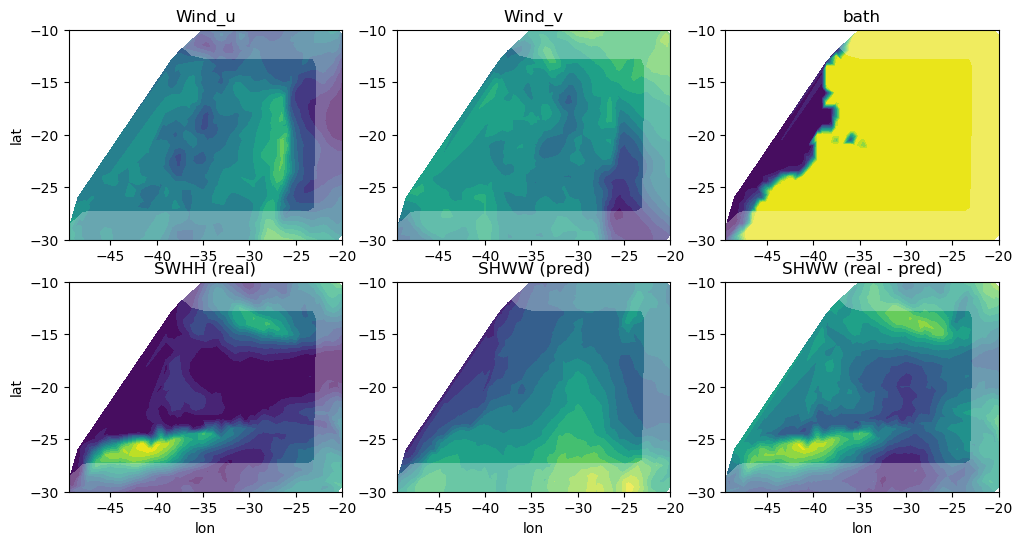

In [80]:
# Plot results
n_contours = 16

plt.figure(figsize=(12,6))

wind_max = np.max((np.max(np.abs(wind_u)),np.max(np.abs(wind_u))))
wave_max = np.max((np.max(np.abs(shww_t)),np.max(np.abs(shww_p))))

contours_wind = wind_max*np.linspace(-1,1,n_contours)
contours_bath = np.linspace(0,1000,n_contours)
contours_wave = wave_max*np.linspace(0,1,n_contours)
contours_distance = [0, pars['train']['distance_to_sea']]

plt.subplot(2,3,1)
plt.tricontourf(lon,lat,wind_u,contours_wind)
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.title('Wind_u')
plt.ylabel('lat')

plt.subplot(2,3,2)
plt.tricontourf(lon,lat,wind_v,contours_wind)
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.title('Wind_v')

plt.subplot(2,3,3)
plt.tricontourf(lon,lat,bath,contours_bath)
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.title('bath')

plt.subplot(2,3,4)
plt.tricontourf(lon,lat,shww_t,contours_wave)
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.title('SWHH (real)')
plt.xlabel('lon')
plt.ylabel('lat')

plt.subplot(2,3,5)
plt.tricontourf(lon,lat,shww_p,contours_wave)
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.xlabel('lon')
plt.title('SHWW (pred)')

plt.subplot(2,3,6)
plt.tricontourf(lon,lat,shww_t-shww_p,n_contours)
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.xlabel('lon')
plt.title('SHWW (real - pred)')

In [81]:
# Print metrics
def ioa(p,o):
    p = p.flatten()
    o = o.flatten()

    return 1 - (np.sum(np.square(o-p))/np.sum(np.square(np.abs(p-np.mean(o))+np.abs(o-np.mean(o)))))

print(f'MSE: {np.mean(np.square(d.shww_norm*(shww_p-shww_t)))}')
print(f'MAE: {np.mean(np.abs(d.shww_norm*(shww_p-shww_t)))}')
print(f'IOA: {ioa(shww_p,shww_t)}')

MSE: 0.8539507985115051
MAE: 0.7839488387107849
IOA: 0.47503966093063354


Text(0, 0.5, 'Loss')

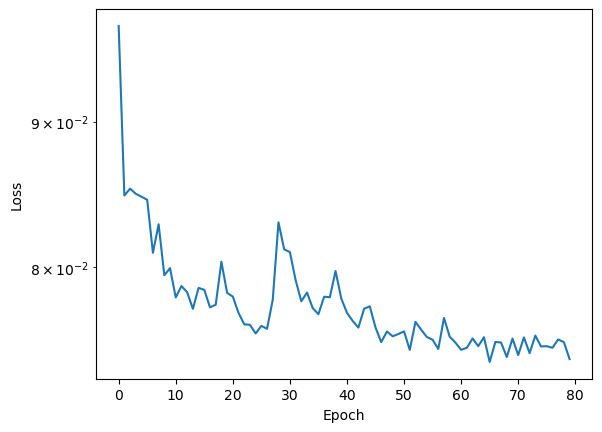

In [82]:
# Plot loss during training
plt.semilogy(model_data['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')